# Code Assigment 1

For this assignment you will use the following SVM implementation for classifying these datasets:

https://archive.ics.uci.edu/ml/datasets/banknote+authentication


https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

You should:

1) Specify which Machine Learning problem are you solving.

2) Provide a short summary of the features and the labels you are working on.

3) Please answer the following questions: a) Are these datasets linearly separable? b) Are these datasets randomly chosen and c) The sample size is enough to guarantee generalization.

4) Provide an explanation how and why the code is working. You can add comments and/or formal explanations into the notebook.

5) Show some examples to illustrate that the method is working properly.

6) Provide quantitative evidence for generalization using the provided dataset.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from models import  train_validation_test_split,SVM
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
np.random.seed(42)


import matplotlib.pyplot as plt
import seaborn as sns

# Bank note model 

1) Specify which Machine Learning problem are you solving.

2) Provide a short summary of the features and the labels you are working on.

3. Please answer the following questions: 
    1. Are these datasets linearly separable? 
    2. Are these datasets randomly chosen.
    3. The sample size is enough to guarantee generalization.

4) Provide an explanation how and why the code is working. You can add comments and/or formal explanations into the notebook.

5) Show some examples to illustrate that the method is working properly.

6) Provide quantitative evidence for generalization using the provided dataset.

## Solution

### 1 Specify which Machine Learning problem are you solving.
The machine learning problem in this case is to detect counterfeit banknotes, the data is obtained from https://archive.ics.uci.edu/ml/datasets/banknote+authentication , in this case we are in front of a classification problem,  where we try to classify each banknote into two possible classes, counterfeits and genuine banknotes, the objective is to maximize the detection of counterfeit banknotes.

In [2]:
# Load the dataset
df_bank_note = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt', header=None)

df_bank_note.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']

In [3]:
df_bank_note['class']=df_bank_note['class'].replace(0,-1)

In [4]:
df_bank_note

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,-1
1,4.54590,8.16740,-2.4586,-1.46210,-1
2,3.86600,-2.63830,1.9242,0.10645,-1
3,3.45660,9.52280,-4.0112,-3.59440,-1
4,0.32924,-4.45520,4.5718,-0.98880,-1
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [5]:
df_bank_note=shuffle(df_bank_note)

In [6]:
df_bank_note['class']

430    -1
588    -1
296    -1
184    -1
244    -1
       ..
1095    1
1130    1
1294    1
860     1
1126    1
Name: class, Length: 1372, dtype: int64

In based on this data,in effect, variance, skewness, curtosis and entropy we want to determine the class of every banknote.

In [7]:
sum(df_bank_note['class']==0)

0

In [8]:
sum(df_bank_note['class']==1)

610

### 2  Provide a short summary of the features and the labels you are working on.

For create this dataset was required to extract the features from images of genuine and forged banknote-like specimens, to do this they use wavelet transformation tool.we are going to introduce briefly the wavelet transformation tool,this transformations works similar to a Fourier tranformation, with the difference that the functions used are wavelets, that is functions of the form:

$$ \psi = -(x-b)e^{\frac{-(x-b)^{2}/2a²}{\sqrt{2\pi}a^{3}}} $$

Were $a$ determines scale and $b$ determines location,the wavelets have the advantage of extract local information , that is, if we want a better model for local information, wavelet transform work better than Fourier tranform, in this case since the genuine banknotes have local information to proof that is in fact genuine (like watermarks and othes markers) this information is so relevant, that is the reason for use wavelet transformation insted of Fourier or other transform,the wavelet transform in the  from this transformation the features want to describe the wavelets distributions,following this reasoning we obtain.

1. variance of Wavelet Transformed image (continuous):
    Over the distribution of wavelets transformation, we want to know his variance, the variance is a interesting value for our problem because a forged banknote probably have diferent ranges that a genuine.
2. Skewness of Wavelet Transformed image (continuous):
    The skewness give us a measure of the simetry of the distribution, we can think that exists a correlation between a class and his simetry of distribution.
3. Curtosis of Wavelet Transformed image (continuous)
    Curtosis is a measure of the density of the distribution,that give us information about the distribution of the pixels and can describe a principal element of the banknote.
    
4. Entropy of image (continuous)
    If we work with pixels like a random variable, the entropy show us the "disorder" or uncertainty in this random variable, the use of specific materials and inks determine if a banknote are genuine or not, this can be characterised with the entropy, because the behaviour of the pixels with some materials can be defined by his entropy.  
5. class (integer)
    In this case we have two categories, the dataset description do not have the meaning of the class, but we could think that 0 is genuine and 1 is forged.

In [9]:
df_bank_note.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,-0.110787
std,2.842763,5.869047,4.310030,2.101013,0.994207
min,-7.042100,-13.773100,-5.286100,-8.548200,-1.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,-1.000000
50%,0.496180,2.319650,0.616630,-0.586650,-1.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


Here we can observe the different statistics measures of the data as a summary of principal statistical information of every variable.

### 3 Answer questions

* ¿Are this dataset linearly separable?

To see that this dataset is linearly separable we have to find a separator hiperplane that induce two partitions, in both cases we only need to find the support vector machine, if we can find it, then the data are linearly separable. But we could also run a logistic regression algorithm to see that we could separate the set of points in two collections, we are going to run a logistic regression algorithm to see that the data are separable and after a SVM algorithm.Also we are going to visualize the dataset and see if the two datasets looks like if were separables,in fact:

Text(0.5, 0.98, 'Marginal plot and distributions')

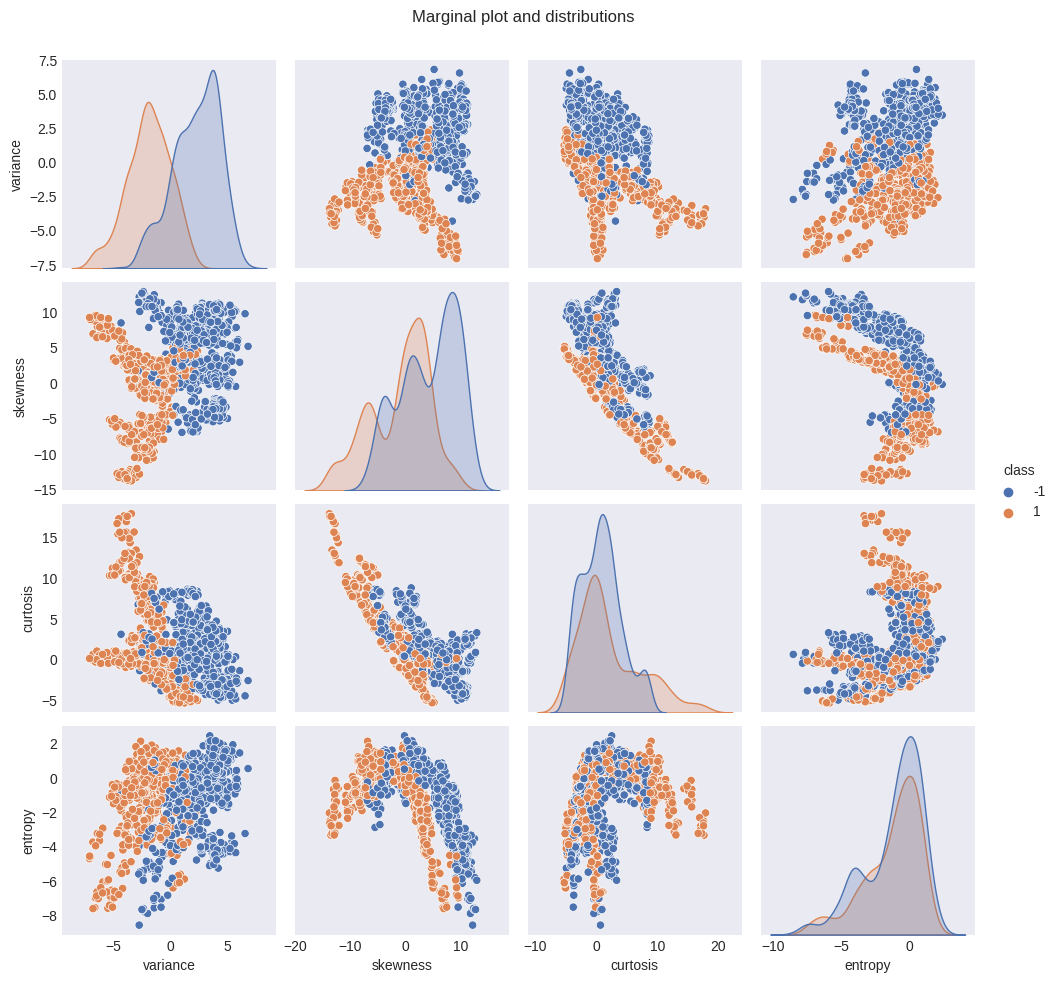

In [10]:
# Visualizing data

pair=sns.pairplot(df_bank_note, hue="class",palette='deep')
pair.fig.subplots_adjust(top=.93)
pair.fig.suptitle('Marginal plot and distributions')

We can see that the distributions of de data in both cases looks different and distinguible one for another.And also we can see a correlation matrix to see that the data are related to the labels.

<AxesSubplot: title={'center': 'Correlation Matrix'}>

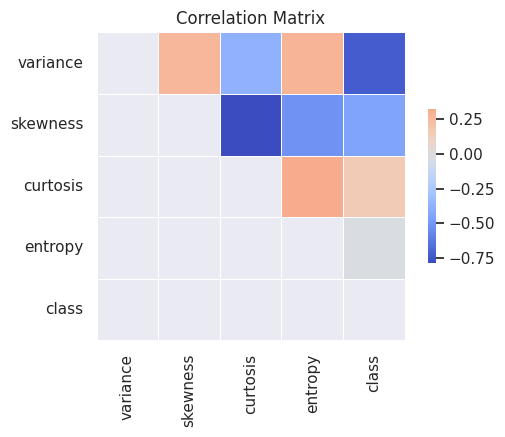

In [11]:
sns.set_theme(style="dark")
corr = df_bank_note.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)).T
f, ax = plt.subplots(figsize=(6,4))
ax.set_title("Correlation Matrix")
# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, center=0,cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [12]:
X =df_bank_note.drop('class',axis=1).values
y= df_bank_note['class'].values

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_val, X_test, y_train, y_val, y_test= train_validation_test_split(X, y)

Now we are going to see if the data are linearly separable with a logistic regression over all the data

In [13]:
clf = LogisticRegression(tol=0,max_iter=10000)
clf.fit(X,y)

LogisticRegression(max_iter=10000, tol=0)

In [14]:
clf.score(X,y)

0.9715743440233237

With this information we now see that a model can separate with an low error the dataset in to classes. And with this we can say that are linearly separable.

* ¿Are this dataset randomly chosen?

The function  *train_validation_test_split* is designed to randomly choose the data and split in 3 sets, i.e, train, test and validation, we can see that the distribution of the data is preserved, to do this we plot the train data.

Text(0.5, 0.98, 'Marginal plot and distributions')

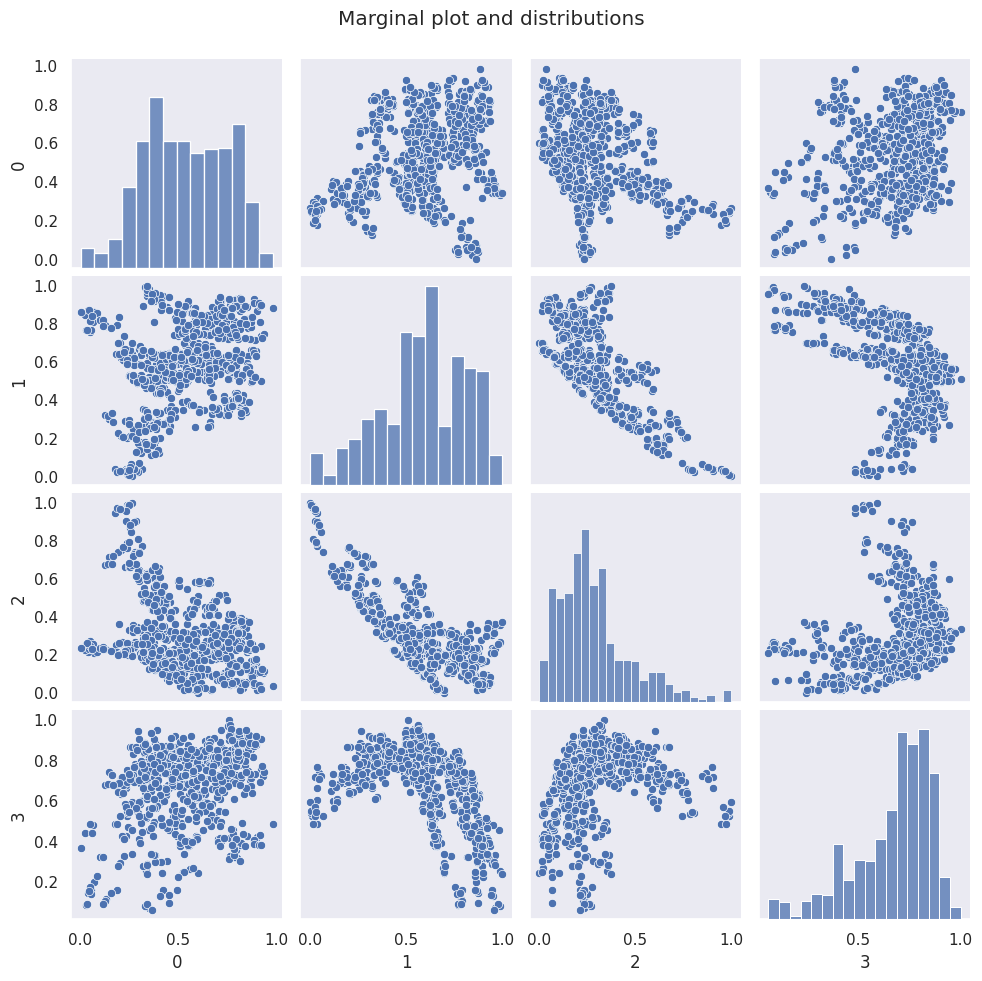

In [15]:
pair=sns.pairplot(pd.DataFrame(X_train))
pair.fig.subplots_adjust(top=.93)
pair.fig.suptitle('Marginal plot and distributions')

In [16]:
X_train.shape

(754, 4)

* The sample size is $754$ and the dimension of every observation are $4$ , the dimesion $VC$ of a support vector machine is $d+1$ , in this case is $5$ then we can use an heuristics that if $N$ fulfil that $10d_{vc}(\mathcal{H})\leq N$ then the model can generalize. In this case $50\leq N$ and for this reason we can give some guarantee of generalization.  

### 4  Provide an explanation how and why the code is working.

To know more about the implementation of the support vector machine, the algorithm of optimization and more, you can check the file *models.py* where are the information and the commented code, in summary we create an object with name *SVM* , now we are going to implement the model.

In [17]:
#Here we create a variable with the object SVM that contains, 
#the model, the optimization algorithm and the evaluation functions
svm = SVM()

This method optimize the algorithm to the data using a form of gradient descent algorithm to optimize the weights and bias of the support vector machine, we determine the data, the epochs and the learning rate, after this the method print the precision and return the weights and bias of the support vector machine.

In [18]:

svm.fit(X_train, y_train,X_val,y_val,learning_rate=0.001,epochs=50,eval_step=5)



Precisión:0.8289124668435013


(array([[-2.71357855, -1.34877142,  0.45364596,  0.47112474]]),
 1.4939999999999984)

### 5 Show some examples to illustrate that the method is working properly.

To do this we create a function with the scaler and the model, in this case we insert the data and see how this works with some examples.

In [19]:
def svm_model(data):
    X=data.drop('class',axis=1).values
    X=scaler.transform(X)
    return svm.predict(X)

We are going to create and visualize a new dataset named **example data**.

In [20]:
example_data=df_bank_note[750:770]
example_data

,variance,skewness,curtosis,entropy,class
504,2.8297,6.348500,-0.73546,-0.58665,-1
1030,-1.8439,-8.647500,7.67960,-0.66682,1
347,3.3299,0.912540,1.58060,0.39352,-1
386,-2.4953,11.147200,1.93530,-3.46380,-1
0,3.6216,8.666100,-2.80730,-0.44699,-1
360,2.7161,-4.200600,4.19140,0.16981,-1
1296,-3.5933,0.229680,0.71260,-0.33320,1
475,3.8213,0.231750,2.01330,2.05640,-1
1175,-1.7549,-0.080711,-0.75774,-0.37070,1
1037,-1.7976,-6.768600,6.67530,0.89912,1


Now we are going to make predictions over the dataset and assigns to a new variable named **Prediction** with this we can see if the model works properly, not only in his accuracy, but also in his type of outputs.

In [21]:
example_data['Prediction']=svm_model(example_data)

/tmp/ipykernel_5491/3269350731.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_data['Prediction']=svm_model(example_data)


In [22]:
example_data

,variance,skewness,curtosis,entropy,class,Prediction
504,2.8297,6.348500,-0.73546,-0.58665,-1,-1.0
1030,-1.8439,-8.647500,7.67960,-0.66682,1,1.0
347,3.3299,0.912540,1.58060,0.39352,-1,-1.0
386,-2.4953,11.147200,1.93530,-3.46380,-1,-1.0
0,3.6216,8.666100,-2.80730,-0.44699,-1,-1.0
360,2.7161,-4.200600,4.19140,0.16981,-1,-1.0
1296,-3.5933,0.229680,0.71260,-0.33320,1,1.0
475,3.8213,0.231750,2.01330,2.05640,-1,-1.0
1175,-1.7549,-0.080711,-0.75774,-0.37070,1,1.0
1037,-1.7976,-6.768600,6.67530,0.89912,1,1.0


### 6 Provide quantitative evidence for generalization using the provided dataset.

Before to provide quantitative evidence we are going to see some metrics of the model, like precision, loss, accuracy and we are going to calculate $|E_{in}-E_{out}|$ to see that $min(\Omega)=\Omega_{min}=|E_{in}-E_{out}|$

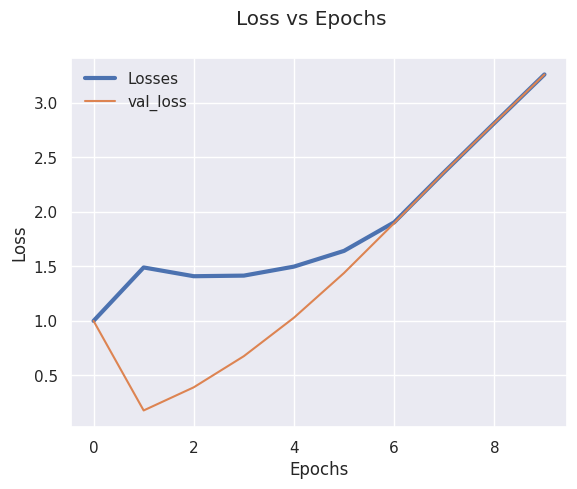

In [23]:
svm.plot_loss()


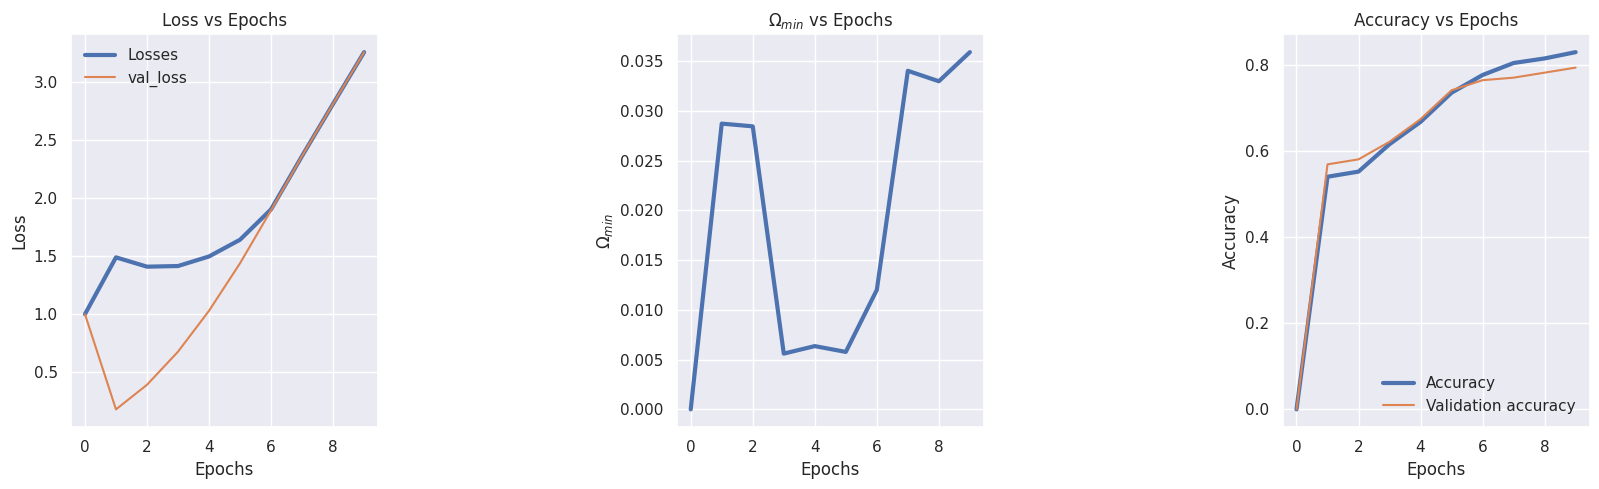

In [24]:
svm.plot_omega()

In [25]:
svm.evaluate_model(X_test,y_test)

True positives:77
True negatives:154
False positives:6
False negatives:77
Precisión: 0.927710843373494
Recall: 0.927710843373494
F1-score: 0.927710843373494


In this case our main metric are the recall, this is because the recall give us a measure of how many banknotes are truly genuine and how many we can fall, in fact we can optimize the model in consideration of the recall because is a better metric for our problem.